In [94]:
import vof
from vof import forecaster
from vof import optimizer

In [95]:
#pip install altair

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

<AxesSubplot:xlabel='Time'>

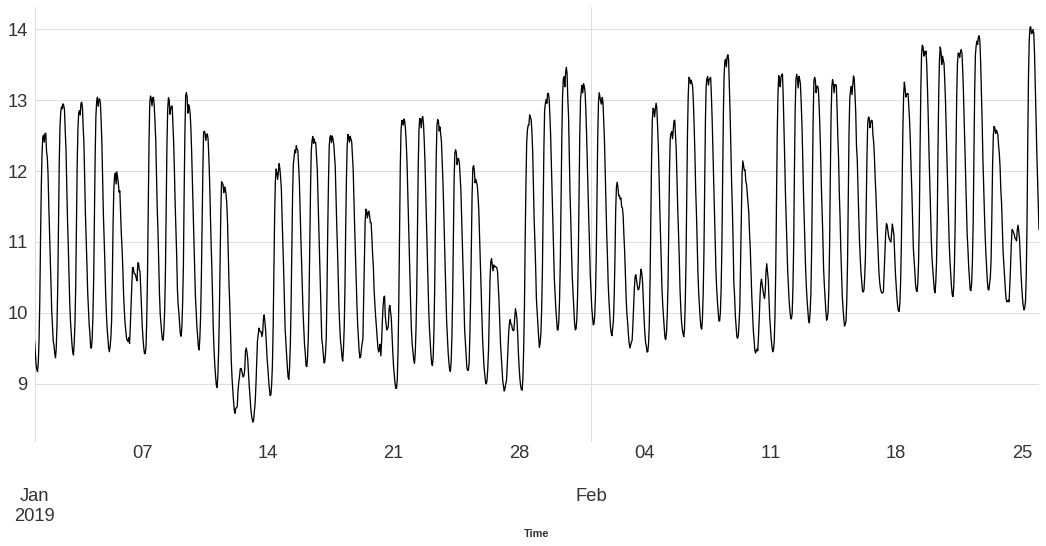

In [141]:
data = pd.read_csv("data/district/Actuals.csv", index_col=0, parse_dates=True).loc['2019-01-01':'2019-02-25']
data.head(5)
data.columns = ['y','Pressure_kpa','Cloud Cover (%)','Humidity (%)','Temperature (C)','Wind Direction (deg)','Wind Speed (kmh)']
data.y = data.y/100000

data.reset_index(inplace=True)
data['sin_hour'] = np.sin(2*np.pi*data.Time.dt.hour/24)
data['cos_hour'] = np.cos(2*np.pi*data.Time.dt.hour/24)

data.set_index('Time', inplace=True)
data.y.plot()

In [142]:
data.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-02-25 14:00:00', '2019-02-25 15:00:00',
               '2019-02-25 16:00:00', '2019-02-25 17:00:00',
               '2019-02-25 18:00:00', '2019-02-25 19:00:00',
               '2019-02-25 20:00:00', '2019-02-25 21:00:00',
               '2019-02-25 22:00:00', '2019-02-25 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=1344, freq=None)

# Creating forecast from Fact data

## Estimating Lags and adding them to the object

In [143]:
# def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
#     pacf = sm.tsa.stattools.pacf(ts, nlags)
#     lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
#     plt.plot(pacf,'*--')
#     plt.plot(lags,pacf[lags],'o')
#     return lags

In [144]:
# lags = estimateSignificantLags(data.y, significantLags = 10)
# # add lags for certain days
# lags = np.unique(np.hstack([lags]))
# print(np.sort(lags))

## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [145]:
input_timeseries = TimeSeries.from_dataframe(data, value_cols=['y'])#[0:-24]
# future = TimeSeries.from_dataframe(data, value_cols=['Pressure_kpa', 'Cloud Cover (%)',
#                                                      'Humidity (%)','Temperature (C)', 
#                                                      'Wind Direction (deg)', 'Wind Speed (kmh)'])
future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)', 'sin_hour', 'cos_hour'])


In [146]:
# We first set aside the first 25% as training series:
input_train, _ = input_timeseries.split_before(0.33)

def eval_model(model, past_covariates=None, future_covariates=None, retrain = False):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    input_timeseries[-len(backtest)-336:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 0.4420317527558713


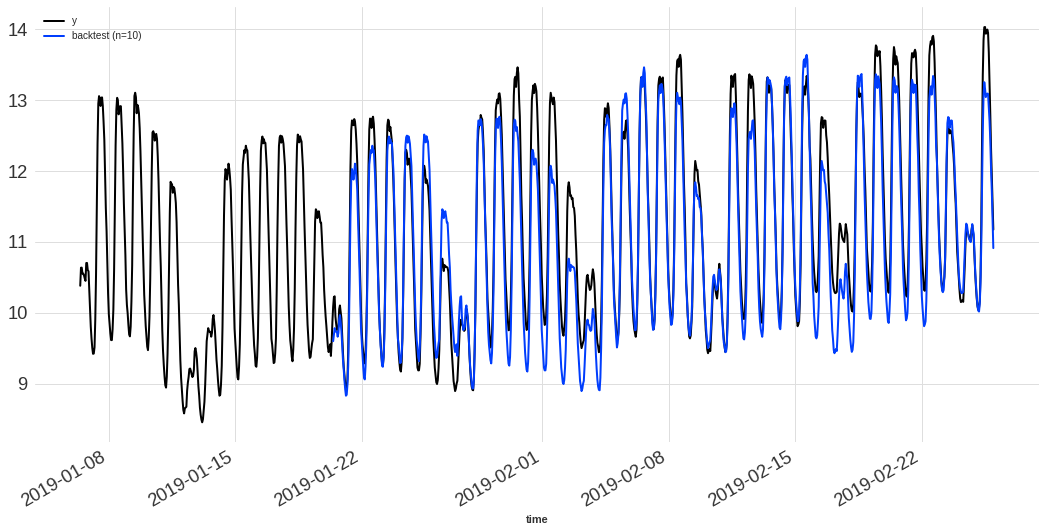

In [147]:
naive_model_weekly = NaiveSeasonal(K=168)
naive_model_weekly.fit(input_train)

eval_model(naive_model_weekly, retrain=True)


  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 0.8801223159573135


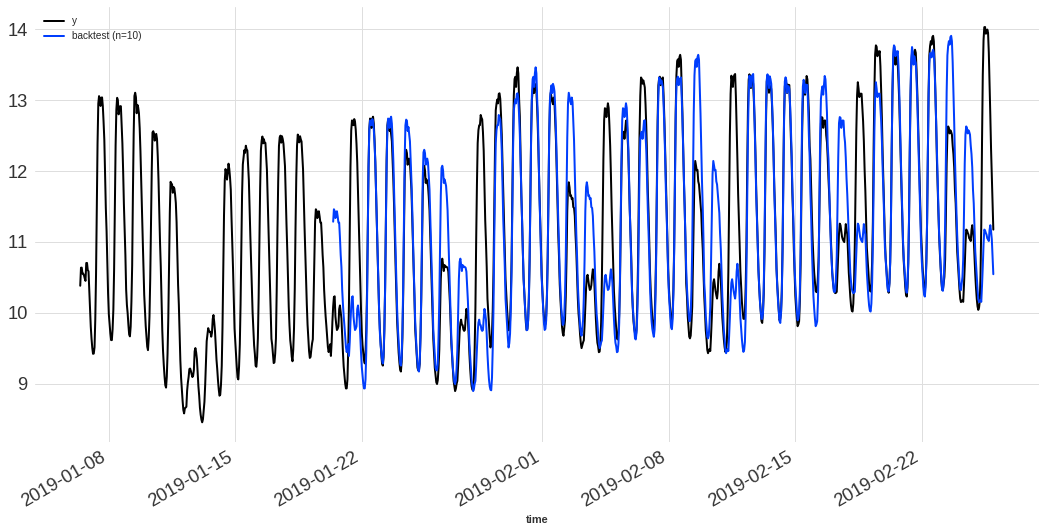

In [148]:
naive_model_daily = NaiveSeasonal(K=24)
naive_model_daily.fit(input_train)

eval_model(naive_model_daily, retrain=True)

  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 0.4984085264045911


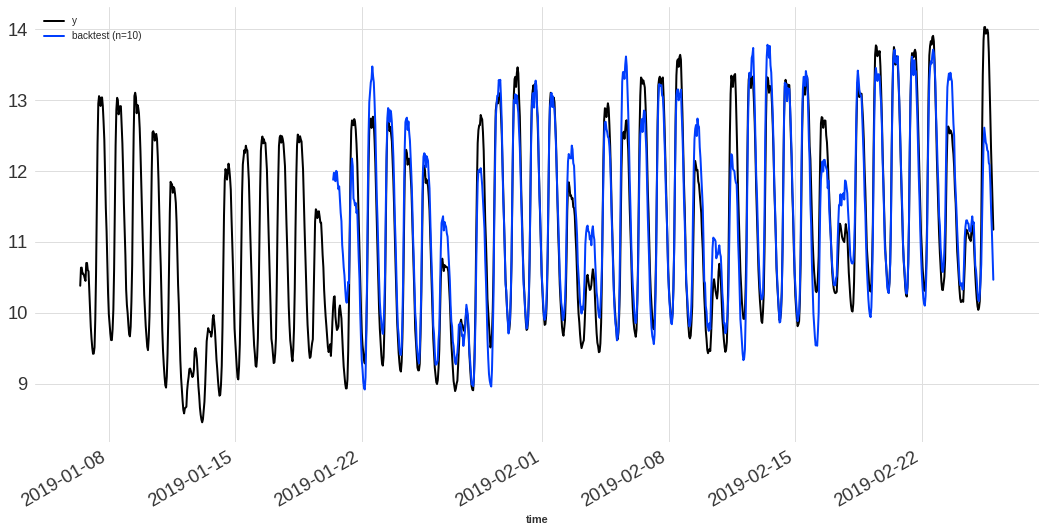

In [149]:
regr_model_lags =  RegressionModel(lags=[-1,   -2,   -3,   -5,  -23,  -24,  -26, -48, -50, -167, -168, -169])
regr_model_lags.fit(input_train)
eval_model(regr_model_lags)


  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 0.5701531726404904


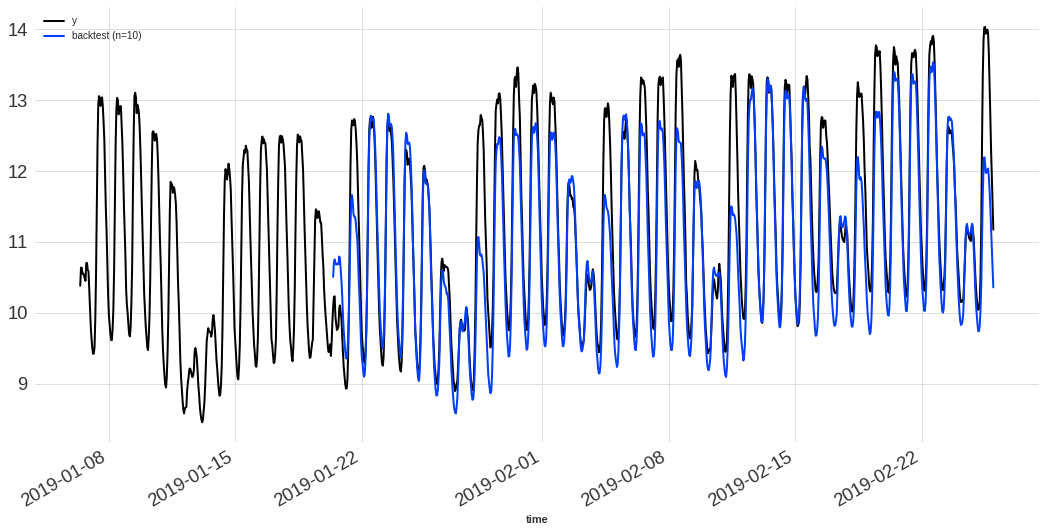

In [150]:
regr_model_lags_18 =  RegressionModel(lags=[-1, -2, -3, -4, -5, -6, -22,  -24,  -26, -46, -48, -50, -166, -168, -170, -334, -336, -338])
regr_model_lags_18.fit(input_train)
eval_model(regr_model_lags_18)


In [ ]:
regr_model_lags_6a =  RegressionModel(lags=[-1,   -2,   -3,   -4,  -5, -6])
regr_model_lags_6a.fit(input_train)
eval_model(regr_model_lags_6a)


In [ ]:
regr_model_lags_6b =  RegressionModel(lags=[-21,   -22,   -24,   -25,  -26, -28])
regr_model_lags_6b.fit(input_train)
eval_model(regr_model_lags_6b)


In [ ]:
regr_model_lags_6c =  RegressionModel(lags=[-166, -167,   -168,   -169,  -170, -172])
regr_model_lags_6c.fit(input_train)
eval_model(regr_model_lags_6c)


In [ ]:
regr_model_cov = RegressionModel(lags=[-1,   -2,   -3,   -5,  -23,  -24,  -26,  -50, -168, -169],
                                 #lags_future_covariates=list(range(-6,72)))
                                 lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)','sin_hour', 'cos_hour'])

regr_model_cov.fit(input_train,
               future_covariates=future)

eval_model(regr_model_cov)


In [ ]:
lgbm_model_cov = LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -22,  -24,  -26, -46, -48, -50, -166, -168, -170, -334, -336, -338],
                              #lags_future_covariates=[0],
                              lags_future_covariates=list(range(0,24))
                              )

future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)', 'sin_hour', 'cos_hour'])

lgbm_model_cov.fit(input_train, future_covariates=future)

eval_model(lgbm_model_cov)


In [ ]:
lgbm_model = LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -22,  -24,  -26, -46, -48, -50, -166, -168, -170, -334, -336, -338])
lgbm_model.fit(input_train)
eval_model(lgbm_model)


  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 0.30086378329932884


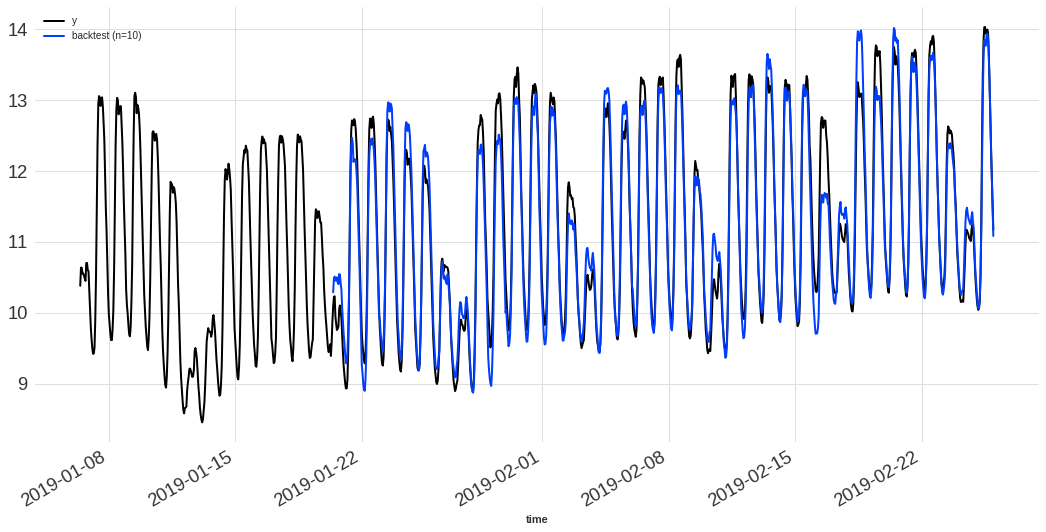

In [13]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

theta_model =  Theta(2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

theta_model.fit(input_train)

eval_model(theta_model, retrain=True)


  0%|          | 0/878 [00:00<?, ?it/s]

Backtest RMSE = 1.0865853632124411


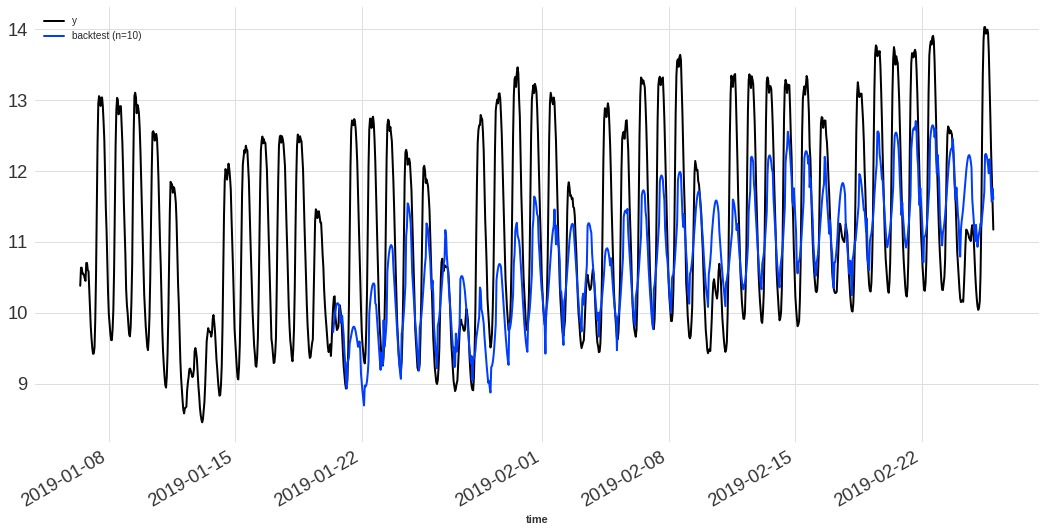

In [14]:
fft_model =  FFT(nr_freqs_to_keep=10, required_matches=set(), trend='poly', trend_poly_degree=2)

fft_model.fit(input_train)

eval_model(fft_model, retrain=True)


In [151]:
def get_historical_forecasts(model, model_display_name, future_covs=False):

    horizon = 168
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                                    forecast_horizon=horizon, stride=24, verbose=True,
                                                    start=672, last_points_only=False, overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                                    forecast_horizon=horizon, stride=24, verbose=True,
                                                    future_covariates=future, overlap_end=False,
                                                    start=672, last_points_only=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-horizon]
    else:
        return res_df


models = {'Naive weekly':[naive_model_weekly,False],
          'Naive daily': [naive_model_daily,False],
          'RegressionModelLags':[regr_model_lags,False],
          'RegressionModelLags18':[regr_model_lags_18,False],
#           'RegressionModelLags6a':[regr_model_lags_6a,False],
#           'RegressionModelLags6b':[regr_model_lags_6b,False],
#           'RegressionModelLags6c':[regr_model_lags_6c,False],
#           'RegressionModelCov':[regr_model_cov,True],
#           'LGBM_cov':[lgbm_model_cov,True],
#           'LGBM_no_cov':[lgbm_model,False],
#           'Theta':[theta_model,False],
#           'FFT':[fft_model,False],
          #'ExponentialSmoothing':[exp_smooth_model,False],
          #'Prophet':[prophet_model,False]
         }

optimization_df = pd.DataFrame()

import time



runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])

for model in models.keys():
    print(model)
    start=time.time()
    optimization_df = optimization_df.append(get_historical_forecasts(model = models[model][0],
                                                                      model_display_name = model,
                                                                      future_covs = models[model][1]), 
                                            ignore_index=True)
    end = time.time()
    runtime_df.loc[model,'runtime'] = (end-start)

Naive weekly


  0%|          | 0/22 [00:00<?, ?it/s]

Naive daily


  0%|          | 0/22 [00:00<?, ?it/s]

RegressionModelLags


  0%|          | 0/22 [00:00<?, ?it/s]

RegressionModelLags18


  0%|          | 0/22 [00:00<?, ?it/s]

In [152]:
optimization_df

ts      value prediction_date                  model
0     2019-01-29 00:00:00   9.729660      2019-01-29           Naive weekly
1     2019-01-29 01:00:00   9.546602      2019-01-29           Naive weekly
2     2019-01-29 02:00:00   9.432373      2019-01-29           Naive weekly
3     2019-01-29 03:00:00   9.331542      2019-01-29           Naive weekly
4     2019-01-29 04:00:00   9.285817      2019-01-29           Naive weekly
...                   ...        ...             ...                    ...
14107 2019-02-24 19:00:00  11.533643      2019-02-18  RegressionModelLags18
14108 2019-02-24 20:00:00  11.458660      2019-02-18  RegressionModelLags18
14109 2019-02-24 21:00:00  11.271890      2019-02-18  RegressionModelLags18
14110 2019-02-24 22:00:00  11.031710      2019-02-18  RegressionModelLags18
14111 2019-02-24 23:00:00  10.742655      2019-02-18  RegressionModelLags18

[14112 rows x 4 columns]

In [153]:
runtime_df

runtime
Naive weekly           0.233573
Naive daily            0.232699
RegressionModelLags    5.088206
RegressionModelLags18  4.076987

In [154]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index('ts', inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.y.loc[fact.index]
fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact, ignore_index=True)


# tmp = optimization_df.groupby(['ts','prediction_date']).mean().reset_index()
# tmp['model'] = 'mean_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).median().reset_index()
# tmp['model'] = 'median_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.05).reset_index()
# tmp['model'] = '5p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.25).reset_index()
# tmp['model'] = '25p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.75).reset_index()
# tmp['model'] = '75p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp= optimization_df.groupby(['ts','prediction_date']).quantile(.95).reset_index()
# tmp['model'] = '95p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# optimization_df.set_index('ts', inplace=True)

In [290]:
noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_1p'
noisy_biased_1p.value = fact.value + 1

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_2p'
noisy_biased_2p.value = fact.value + 2

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_3p'
noisy_biased_3p.value = fact.value + 3

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_4p'
noisy_biased_4p.value = fact.value + 4

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_1n'
noisy_biased_1n.value = fact.value - 1

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_2n'
noisy_biased_2n.value = fact.value - 2

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_3n'
noisy_biased_3n.value = fact.value - 3

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_4n'
noisy_biased_4n.value = fact.value - 4

optimization_df = optimization_df.append(noisy_biased_1p, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_2p, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_3p, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_4p, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_1n, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_2n, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_3n, ignore_index=True)
optimization_df = optimization_df.append(noisy_biased_4n, ignore_index=True)


In [17]:
np.random.seed(42)

noisy_normal_0u_1s = fact.copy()
noisy_normal_0u_1s.model = 'noisy_normal_0u_1s'
noisy_normal_0u_1s.value = fact.value + np.random.uniform(-1,1,len(fact))

noisy_normal_0u_2s = fact.copy()
noisy_normal_0u_2s.model = 'noisy_normal_0u_2s'
noisy_normal_0u_2s.value = fact.value + np.random.uniform(-2,2,len(fact))

noisy_normal_0u_3s = fact.copy()
noisy_normal_0u_3s.model = 'noisy_normal_0u_3s'
noisy_normal_0u_3s.value = fact.value + np.random.uniform(-3,3,len(fact))

noisy_normal_0u_4s = fact.copy()
noisy_normal_0u_4s.model = 'noisy_normal_0u_4s'
noisy_normal_0u_4s.value = fact.value + np.random.uniform(-4,4,len(fact))

optimization_df = optimization_df.append(noisy_normal_0u_1s)
optimization_df = optimization_df.append(noisy_normal_0u_2s)
optimization_df = optimization_df.append(noisy_normal_0u_3s)
optimization_df = optimization_df.append(noisy_normal_0u_4s)


In [18]:
np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)

In [19]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact

ts      value prediction_date model  \
0   2019-01-29 00:00:00  10.008434      2019-01-29  Fact   
1   2019-01-29 01:00:00   9.799795      2019-01-29  Fact   
2   2019-01-29 02:00:00   9.655707      2019-01-29  Fact   
3   2019-01-29 03:00:00   9.511328      2019-01-29  Fact   
4   2019-01-29 04:00:00   9.571445      2019-01-29  Fact   
..                  ...        ...             ...   ...   
643 2019-02-24 19:00:00  11.236766      2019-02-24  Fact   
644 2019-02-24 20:00:00  11.149644      2019-02-24  Fact   
645 2019-02-24 21:00:00  11.038298      2019-02-24  Fact   
646 2019-02-24 22:00:00  10.784431      2019-02-24  Fact   
647 2019-02-24 23:00:00  10.545304      2019-02-24  Fact   

     time_since_prediction  
0                      0.0  
1                      1.0  
2                      2.0  
3                      3.0  
4                      4.0  
..                     ...  
643                   19.0  
644                   20.0  
645                   21.0  
646                   22.0  
647                   23.0  

[648 rows x 5 columns]

In [20]:
np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)

In [21]:
optimization_df

ts      value prediction_date  \
0   2019-01-29 00:00:00   9.729660      2019-01-29   
1   2019-01-29 01:00:00   9.546602      2019-01-29   
2   2019-01-29 02:00:00   9.432373      2019-01-29   
3   2019-01-29 03:00:00   9.331542      2019-01-29   
4   2019-01-29 04:00:00   9.285817      2019-01-29   
..                  ...        ...             ...   
643 2019-02-24 19:00:00  12.878387      2019-02-24   
644 2019-02-24 20:00:00   8.847748      2019-02-24   
645 2019-02-24 21:00:00  12.927637      2019-02-24   
646 2019-02-24 22:00:00  13.567115      2019-02-24   
647 2019-02-24 23:00:00  13.109572      2019-02-24   

                          model  time_since_prediction  
0                  Naive weekly                    NaN  
1                  Naive weekly                    NaN  
2                  Naive weekly                    NaN  
3                  Naive weekly                    NaN  
4                  Naive weekly                    NaN  
..                          ...                    ...  
643  noisy_horizon_dependent_40                   19.0  
644  noisy_horizon_dependent_40                   20.0  
645  noisy_horizon_dependent_40                   21.0  
646  noisy_horizon_dependent_40                   22.0  
647  noisy_horizon_dependent_40                   23.0  

[14904 rows x 5 columns]

In [155]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N'
).properties(width=600, height=150).interactive()


alt.Chart(...)

# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

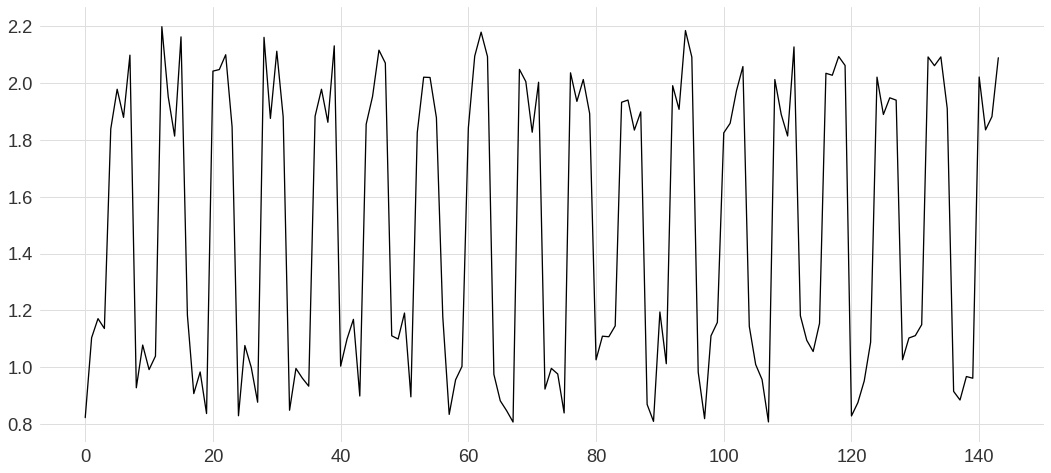

In [156]:
price = [1,1,1,1,2,2,2,2,1,1,1,1,2,2,2,2,1,1,1,1,2,2,2,2] * int(144 / 24)
price = price + np.random.uniform(-.2,.2,len(price))
plt.plot(price)

In [181]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 13
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 10
        self.BATTERY_EFFICIENCY = .99
        self.INVERTER_CAPACITY = 2
        
#         self.price = list(np.append(np.append(np.ones(6), 2*np.ones(12)), np.ones(6))) * int(self.TIME_HORIZON / 24)
#         self.price = [1,1,1,1,2,2,2,2,1,1,1,1,2,2,2,2,1,1,1,1,2,2,2,2] * int(self.TIME_HORIZON / 24)
        self.price = [1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4] * int(self.TIME_HORIZON / 24)
#         self.price = self.price + np.random.uniform(-.2,.2,len(self.price))

    def cost_function(self, solution, battery_charge):
        
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.data.loc[self.data.model==target,'value']+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = - np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000
        
        #penalty for carbon emissions
        carbon_emissions = np.sum(self.price * grid_load) * 10000
        
        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000
        
        total_cost = violations_battery + violations_demand + battery_usage + carbon_emissions + violations_peak
        
        return total_cost
    
    def cost_function_peak(self, solution, battery_charge):
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.data.loc[self.data.model==target,'value']+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        return total_cost
    
        
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.prediction_date.unique()

        #recommendation = np.array([])
        recommendation = pd.Series()
        battery_ch = self.BATTERY_CHARGE

        for step in total_steps:
            print(step)
            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
            instru = ng.p.Instrumentation(par,battery_ch)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=30000)

            try:
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
            except:
                #print(self.optimal_decisions_df.shape)
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            step_recommendation = optimizer.minimize(self.cost_function)

            #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
            #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
            
            recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                             index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
            battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
        
        return pd.Series(name=model, data=recommendation)
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
        
        #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

                
        #for i in parallel_optimal_decision_result:
        #    self.optimal_decisions_df.iloc[:,i.name] = i.values

        return self.optimal_decision_result#self.optimal_decisions_df
    
    def evaluate(self):
        
        evaluation_df = pd.DataFrame(index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        actual_demand = self.data.loc[self.data.model=='Fact','value'].reset_index().value
        
        for i in range(len(self.optimal_decision_result)):  
            evaluation_df.loc[i,'model'] = self.optimal_decision_result[i].name
            
            predicted_demand = self.data.loc[self.data.model==self.optimal_decision_result[i].name,'value'].reset_index().value
            evaluation_df.loc[i,'error_evaluation'] = np.mean(np.abs(actual_demand - predicted_demand))
            
            flexible_demand = self.optimal_decision_result[i].values
            cost_signal = list(self.price) * int(len(self.optimal_decision_result[i])/24)
            evaluation_df.loc[i,'carbon_evaluation'] = np.sum((actual_demand + flexible_demand) * cost_signal)
            
            evaluation_df.loc[i,'peak_evaluation'] = (self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])[(self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
            #print(evaluation_df)
            
        return evaluation_df

    def evaluate_peak(self):
        
        evaluation_df = pd.DataFrame(index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        for i in range(len(self.optimal_decision_result)):  
            evaluation_df.loc[i,'model'] = self.optimal_decision_result[i].name
            evaluation_df.loc[i,'cost_evaluation'] = (self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])[(self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
            evaluation_df.loc[i,'error_evaluation'] = np.mean(np.abs(self.data.loc[self.data.model=='Fact','value'] - self.data.loc[self.data.model==self.optimal_decision_result[i].name,'value']))
            #print(evaluation_df)
            
        return evaluation_df
    
    def evaluate_no_control_case(self):
        evaluation_df = pd.DataFrame(index=[0])#index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        evaluation_df['model'] = 'Fact (no control)'
        evaluation_df['cost_evaluation'] = (self.data.loc[self.data.model=='Fact','value'])[(self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
        evaluation_df['error_evaluation'] = 0
        
        return evaluation_df
        
    def select_value_optimal_hyperparameters():
        return
    

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [182]:
odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

In [183]:

# odm.data.prediction_date[0] 
# input_timeseries

In [184]:
#odm.calculate_optimal_decision('RegressionModelCov')
#optimization_df.model.value_counts()

## Running optimization to select the optimal model

In [185]:
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())
#sol


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.1min remaining: 18.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.2min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.2min finished


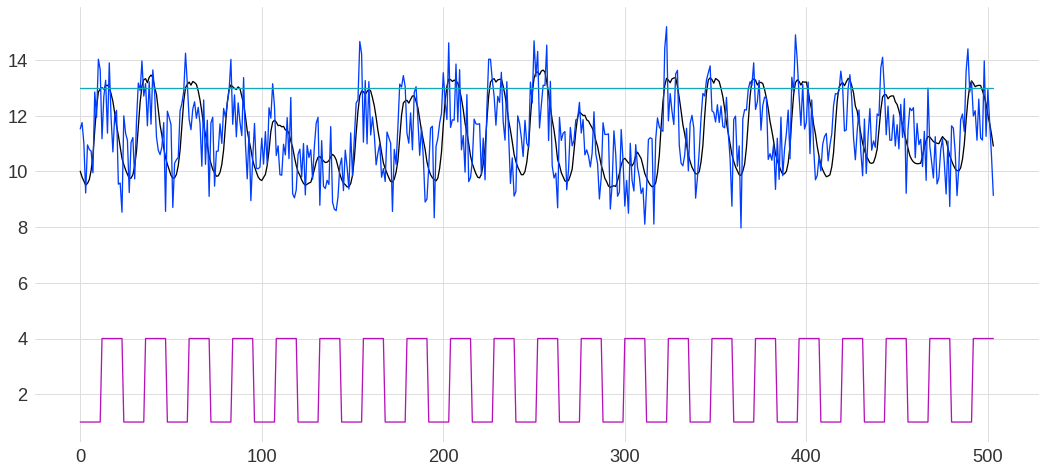

In [190]:
# plt.plot(sol[0].values[0:504])
plt.plot(data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values)
# plt.plot(sol[0].values[0:504] + data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values)
plt.plot(sol[1].values[0:504] + data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values)
plt.plot(odm.price*3)
plt.plot(13*np.ones(504))


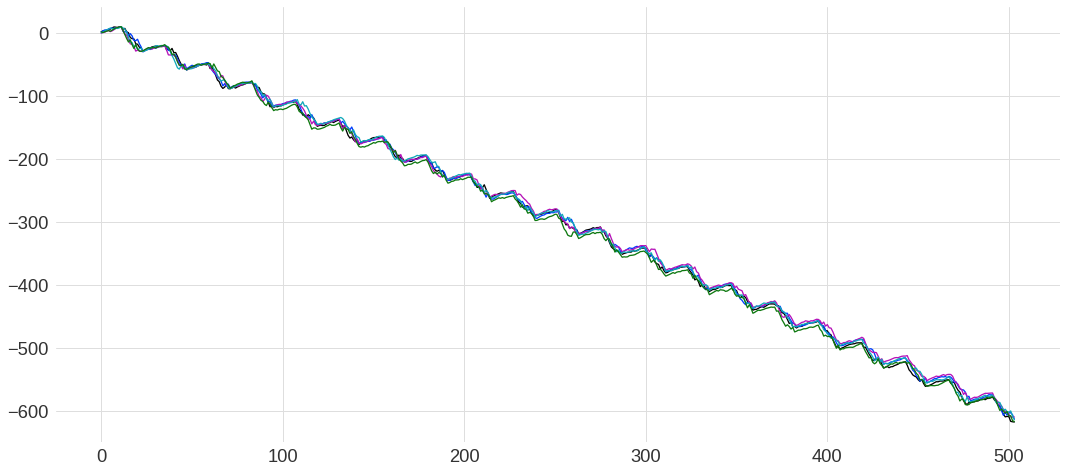

In [191]:
# sol[2].values * 
plt.plot(np.cumsum(sol[0].values[0:504] * (odm.price * 3)))
plt.plot(np.cumsum(sol[1].values[0:504] * (odm.price * 3)))
plt.plot(np.cumsum(sol[2].values[0:504] * (odm.price * 3)))
plt.plot(np.cumsum(sol[3].values[0:504] * (odm.price * 3)))
plt.plot(np.cumsum(sol[4].values[0:504] * (odm.price * 3)))

In [91]:
len(sol[0])

504

In [192]:
print((np.sum(sol[0].values[0:504*1] * (odm.price * 3))),
      (np.sum(sol[1].values[0:504*1] * (odm.price * 3))),
      (np.sum(sol[2].values[0:504*1] * (odm.price * 3))),
      (np.sum(sol[3].values[0:504*1] * (odm.price * 3))),
      (np.sum(sol[4].values[0:504*1] * (odm.price * 3))))

-616.9552729430615 -612.5037060831005 -608.8524035093337 -613.2006658950838 -616.170564657149


In [134]:
np.array((odm.price * 6)) + 1

array([2, 2, 2, ..., 5, 5, 5])

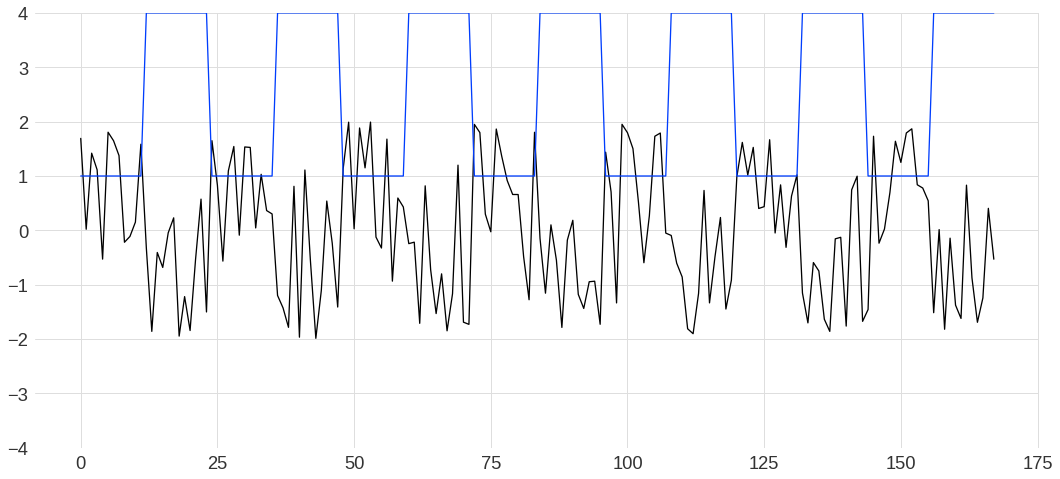

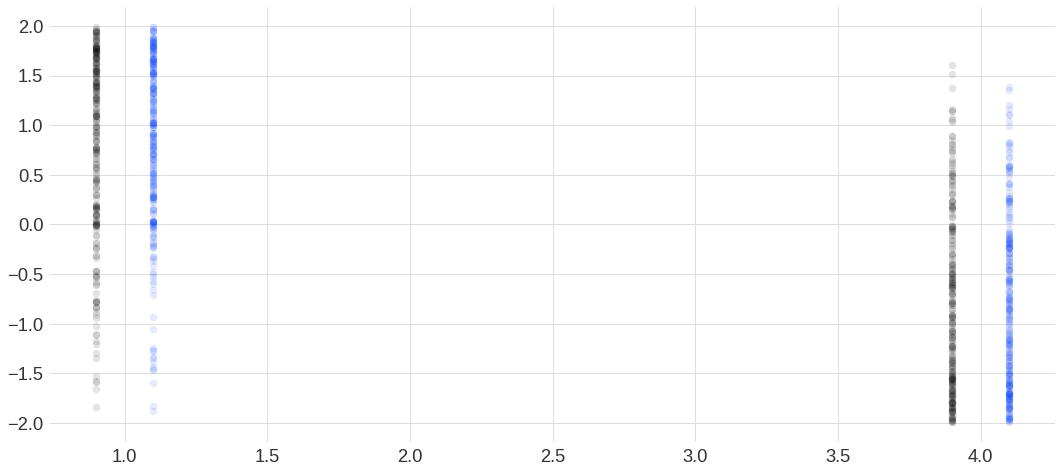

In [171]:
sol[2].reset_index().iloc[0:168,1].plot()
plt.plot(odm.price)
plt.ylim(-4,4)
plt.show()

plt.scatter(np.array((odm.price * 3)) - .1, sol[0].values[0:504*1], alpha=0.1)
plt.scatter(np.array((odm.price * 3)) + .1, sol[2].values[0:504*1], alpha=0.1)
# plt.scatter((odm.price * 6), sol[0].values[0:504*2], alpha=0.1)
# plt.scatter((odm.price * 6), sol[0].values[0:504*2], alpha=0.1)

<AxesSubplot:>

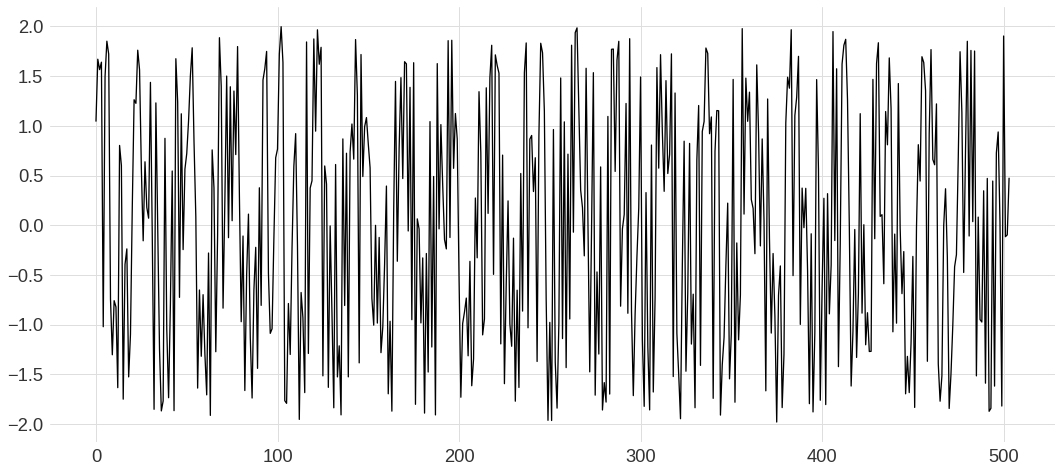

In [59]:
sol[2].reset_index().iloc[:,1].plot()

In [57]:
for i in len(sol):
    sol[i].reset_index().iloc[:,0].plot()

3

In [32]:
# odm.optimal_decision_result[2].values
# odm.data[odm.data.model=='Fact']
odm.optimal_decision_result[2]

7056     1.710882
7057     1.341652
7058    -0.437885
7059     0.011898
7060     0.506770
           ...   
10435   -0.541484
10436   -0.020552
10437    0.946706
10438    0.469907
10439   -0.208647
Name: Fact, Length: 504, dtype: float64

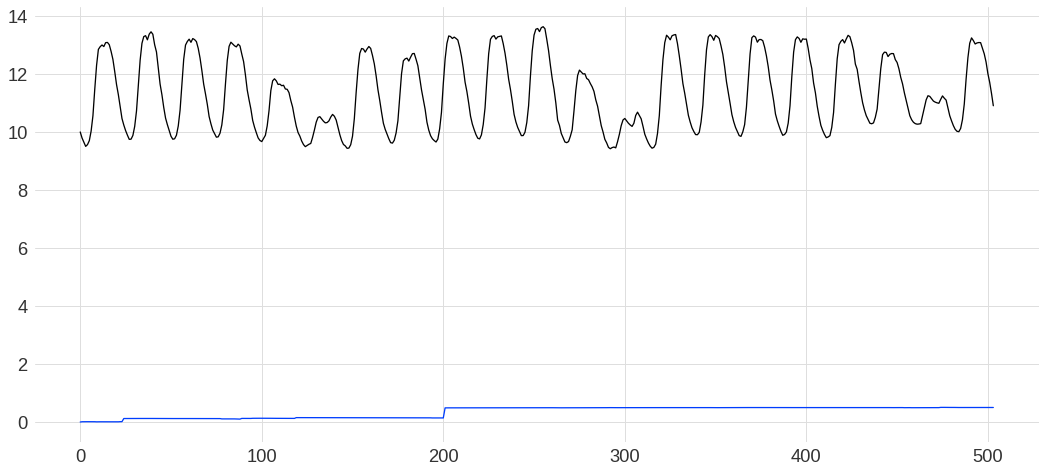

In [405]:
# (odm.data[odm.data.model=='Fact'].reset_index().value + odm.optimal_decision_result[2].values).plot()
# (odm.data[odm.data.model=='Fact'].reset_index().value).plot()
# plt.plot(data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values)
# plt.plot(odm.optimal_decision_result[2].values)

plt.plot(data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values)

plt.plot(np.cumsum(odm.optimal_decision_result[3].values))

# plt.plot(np.cumsum(odm.optimal_decision_result[0].values))

# plt.xlim(0,168)

# plt.plot(np.cumsum(odm.optimal_decision_result[1].values))
# odm.data.model.unique()
# odm.data[odm.data.model=='noisy_biased_4n'].reset_index().value

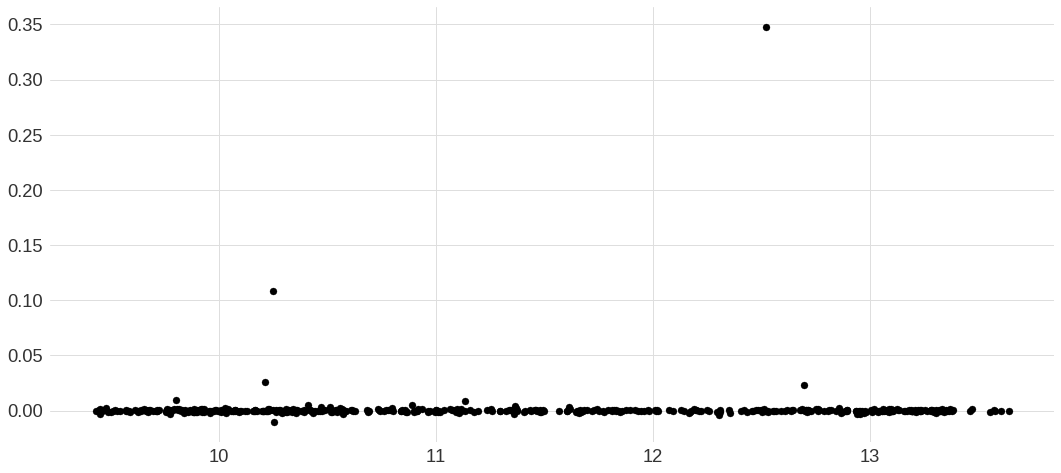

In [406]:
plt.scatter(data.y[odm.data.prediction_date[0]:odm.data.prediction_date[0] + np.timedelta64(len(sol[0])-1, 'h')].values,
           odm.optimal_decision_result[3].values)


In [391]:
sol[0]

0       0.511778
1       0.554171
2       0.817924
3       0.319924
4       0.511903
          ...   
3379   -0.122454
3380    0.015353
3381    0.007949
3382   -0.204726
3383   -1.406138
Name: Naive weekly, Length: 504, dtype: float64

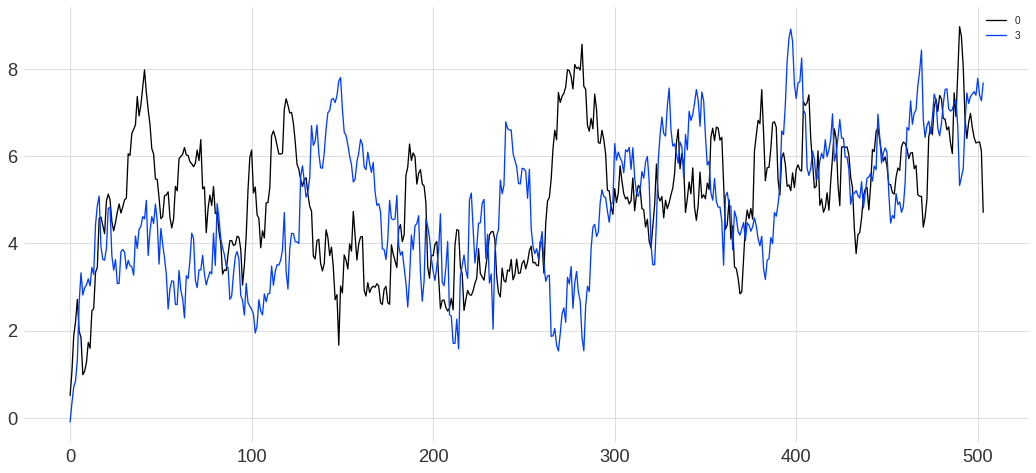

In [392]:
# avg_control = 
for col in [0,3]:#range(len(sol)):
    plt.plot(np.cumsum(sol[col].reset_index().iloc[:,1].dropna()),label=str(col))
# plt.plot(20 * np.array(4*odm.price))
#     plt.ylim(-2,2)
#     plt.xlim(0,168)
#     plt.show()
plt.legend()

## Evaluation returns outputs of cost function for each of the models:

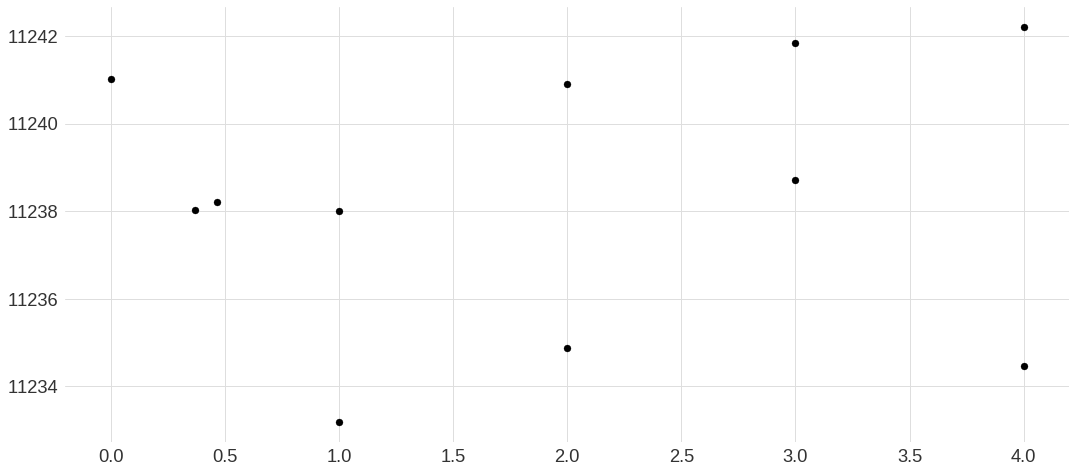

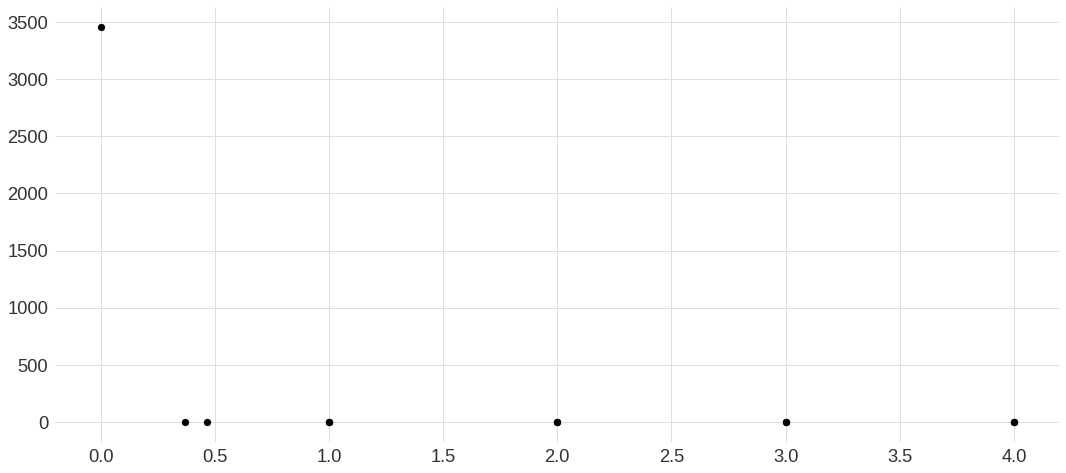

model cost_evaluation error_evaluation  carbon_evaluation  \
0      Naive weekly             NaN         0.370706       11238.039116   
1       Naive daily             NaN         0.466125       11238.211810   
2              Fact             NaN              0.0       11241.028955   
3   noisy_biased_1p             NaN              1.0       11238.015150   
4   noisy_biased_2p             NaN              2.0       11234.878124   
5   noisy_biased_3p             NaN              3.0       11238.705238   
6   noisy_biased_4p             NaN              4.0       11242.212312   
7   noisy_biased_1n             NaN              1.0       11233.188433   
8   noisy_biased_2n             NaN              2.0       11240.912050   
9   noisy_biased_3n             NaN              3.0       11241.834296   
10  noisy_biased_4n             NaN              4.0       11234.468990   

    peak_evaluation  
0          0.000000  
1          0.000000  
2       3457.589426  
3          0.000000  
4          0.000000  
5          0.000000  
6          0.000000  
7          0.000000  
8          0.000000  
9          0.000000  
10         0.000000

In [260]:
EVALUATE = True
results = odm.evaluate()
#plt.scatter(results[0],results[1])

plt.scatter(results['error_evaluation'],results['carbon_evaluation'])
plt.show()

plt.scatter(results['error_evaluation'],results['peak_evaluation'])
plt.show()

# results = results.append(odm.evaluate_no_control_case(), ignore_index=True)
# results = results.join(runtime_df, how='left', on='model')

results


In [181]:
'''line = pd.DataFrame({
    'Goals Conceded': [0, 2],
    'Goals': [0, 2],
})

line_plot = alt.Chart(line).mark_line(color= 'red').encode(
    x= 'Goals Conceded',
    y= 'Goals'.
)

line_plot'''

"line = pd.DataFrame({\n    'Goals Conceded': [0, 2],\n    'Goals': [0, 2],\n})\n\nline_plot = alt.Chart(line).mark_line(color= 'red').encode(\n    x= 'Goals Conceded',\n    y= 'Goals'.\n)\n\nline_plot"

In [221]:
chart = alt.Chart(results.loc[results.model != 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)

chart2 = alt.Chart(results.loc[results.model == 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)


chart +chart2+ chart.transform_regression('error_evaluation', 'cost_evaluation', method='poly').mark_line()

alt.LayerChart(...)

In [41]:
# results.to_csv('results/VOF_20m_90d_h120.csv')